# Braket Tutorial Notebook

Braket is a quantum computing platform that is found on Amazon Web Services (AWS). It can be used to research and explore different types of quantum computers including superconducting, trapped ion, and neutral-atom based qubits without the need for long term subscriptions or complicated set ups. The pay-as-you-go model of AWS Braket ensures that individuals have access to physical quantum machines, but only pay for use time. Due to its integration with other AWS cloud tools, Braket is a great place to try [Hybrid quantum-classical algorithms](https://github.com/amazon-braket/amazon-braket-examples/tree/main/examples/hybrid_quantum_algorithms).

Amazon provides a [detailed walkthrough](https://explore.skillbuilder.aws/learn/public/learning_plan/view/1986/amazon-braket-badge-knowledge-badge-readiness-path) of Braket through their AWS Skills Builder. Feel free to enroll in the free course to learn more about Braket's use cases. 

To run this notebook, [create or log into an AWS account](https://aws.amazon.com/). Once logged into the AWS Management Console, you will need to set up the AWS Command Line Interface (CLI) so we can run code to set up rather than navigate through the Management Console.

Follow these steps in order to set up the necessary AWS environment:

1. While in the Management Console, search for "IAM" and click "Users", then "Create User". Name your user (something like "myBraketCLI") and hit next. Select "Attach policies directly", then check the box corresponding to "AdministratorAccess" and hit next, then Create User. You should be redirected to the Users page, click on the User we just created. Under "Security Credentials", scroll down to "Access Keys" and click Create access key, then select "Command Line Interface (CLI)", check the confirmation box at the bottom, and hit next. A description tag is optional, then hit Create Access Key. ***IMPORTANT*** On the page that follows, we need the "Access key" and the "Secret access key", ***DO NOT CLICK DONE UNTIL AFTER STEP 2 or the keys will be lost and you will need to restart.***
    
2. Install the [AWS CLI SDK v2](https://docs.aws.amazon.com/cli/latest/userguide/getting-started-install.html). Once installed, open a terminal window and configure your machine by running "aws configure". Enter the access and secret keys from step 1. For the region, we will need to select a region with access to Braket, here we will use "us-east-1", and use "json" for the default format. Test your installation with the command "aws --version", and if it works, you can click "Done" for step 1.

3. In the Management Console, search for "Amazon Braket". Make sure your region is set to one of the available regions (such as "us-east-1"). We will assume that you are a new Amazon Braket user, but if not follow [these instructions](https://docs.aws.amazon.com/braket/latest/developerguide/braket-get-started-create-notebook.html). Click on "Get Started" and follow the setup, clicking Accept for each window. This creates a service-linked role for Braket under your AWS account, which can be seen under "IAM -> Roles -> AWSServiceRoleForAmazonBraket". Additionally, this creates a Jupyter Notebook that is already set up with all dependencies and can be accessed through the AWS Management Console under "Amazon Braket -> Notebooks -> YOUR-NOTEBOOK-NAME". This can be used directly for future experimentation, but we will not be using it within this tutorial.

4. To allow for hybrid jobs, go to the AWS Management Console -> Amazon Braket -> Permissions and settings -> Execution roles. Scroll to Hybrid jobs execution role, and try "Verify existing roles". If no role exists, click "Create default role".

***DISCLAIMER:*** You must gain explicit permission to run Hybrid Jobs at this point. To do so, go to AWS Management Console -> Support -> Your support cases -> Create Case -> Account and billing -> Service = "Account Activation", Category = "Account Verification" -> Next steps, ask here for permission (which might take a few days for customer support). If you would like to run Hybrid Jobs through the AWS CLI (including this notebook), you must be running Python 3.10 as of date. Otherwise, you may create a [customized container](https://docs.aws.amazon.com/braket/latest/developerguide/braket-jobs-byoc.html) or run them through the AWS Management Console -> Amazon Braket -> Hybrid Jobs -> Create hybrid job, follow the prompts to set up.


# Dependencies for Amazon Braket SDK

(Following [these steps](https://github.com/amazon-braket/amazon-braket-sdk-python) to set up the AWS Braket Software Development Kit)

Below are the following packages that must be installed:

`pip install boto3`

`pip install amazon-braket-sdk`

`pip install numpy`

`pip install matplotlib`

`pip install matplotlib-inline`




In [28]:
import boto3
from braket.aws import AwsDevice, AwsQuantumTask
from braket.circuits import Circuit, Gate, Noise, FreeParameter, Observable
from braket.devices import LocalSimulator
from braket.jobs.hybrid_job import hybrid_job
from braket.jobs.metrics import log_metric

import string
import numpy
import matplotlib.pyplot as plt
%matplotlib inline


# 1. Creating Simple Circuits and Local Simulations

Let's begin building some quantum circuits with the Circuit class. Below are some simple examples of well known gates, as well as how they look printed out.

In [55]:
print("Pauli X Gate:")
Pauli_X = Circuit().x(0)
print(Pauli_X)

print("\n\nCNOT Gate:")
CNOT = Circuit().cnot(control=0,target=1)
print(CNOT)

print("\n\nHadamard Gate:")
Hadamard = Circuit().h(0)
print(Hadamard)

Pauli X Gate:
T  : │  0  │
      ┌───┐ 
q0 : ─┤ X ├─
      └───┘ 
T  : │  0  │


CNOT Gate:
T  : │  0  │
            
q0 : ───●───
        │   
      ┌─┴─┐ 
q1 : ─┤ X ├─
      └───┘ 
T  : │  0  │


Hadamard Gate:
T  : │  0  │
      ┌───┐ 
q0 : ─┤ H ├─
      └───┘ 
T  : │  0  │


We can also chain gates together to create longer quantum circuits. By passing the qubit number (starting with 0) to the Circuit methods, Braket will automatically include the qubit in the circuit.

In [56]:
bell_state = Circuit().h(0).cnot(control=0,target=1)
print("Bell State Circuit:")
print(bell_state)

Bell State Circuit:
T  : │  0  │  1  │
      ┌───┐       
q0 : ─┤ H ├───●───
      └───┘   │   
            ┌─┴─┐ 
q1 : ───────┤ X ├─
            └───┘ 
T  : │  0  │  1  │


See all of the available gates in the Amazon Braket SDK by running the below code:

In [57]:
for gate in dir(Gate):
    if gate[0] in string.ascii_uppercase:
        print(gate)

CCNot
CNot
CPhaseShift
CPhaseShift00
CPhaseShift01
CPhaseShift10
CSwap
CV
CY
CZ
ECR
GPhase
GPi
GPi2
H
I
ISwap
MS
PRx
PSwap
PhaseShift
PulseGate
Rx
Ry
Rz
S
Si
Swap
T
Ti
U
Unitary
V
Vi
X
XX
XY
Y
YY
Z
ZZ


If you want to create your own unitary transformation, create a numpy matrix and pass it to the Circuits.unitary() method. Here we create the "open CNOT" gate, which flips the state of the target if the control is state |0>.

In [58]:
open_cnot = numpy.array([[0,1,0,0],
                        [1,0,0,0],
                        [0,0,1,0],
                        [0,0,0,1]])

open_cnot_gate = Circuit().unitary(matrix=open_cnot, targets=[0,1])

print("Open CNOT Unitary:")
print(open_cnot_gate.to_unitary())

print("\nOpen CNOT Gate:")
print(open_cnot_gate)

Open CNOT Unitary:
[[0.+0.j 1.+0.j 0.+0.j 0.+0.j]
 [1.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 1.+0.j]]

Open CNOT Gate:
T  : │  0  │
      ┌───┐ 
q0 : ─┤ U ├─
      └─┬─┘ 
      ┌─┴─┐ 
q1 : ─┤ U ├─
      └───┘ 
T  : │  0  │


Let's make sure the unitary we created has the correct expected output by comparing it to an equivalent circuit:

In [59]:
open_cnot_circuit = Circuit().x(0).cnot(control=0,target=1).x(0)
print("Equivalent open CNOT circuit:")
print(open_cnot_circuit)

print("\nComparison:\n", open_cnot_circuit.to_unitary() == open_cnot_gate.to_unitary())

Equivalent open CNOT circuit:
T  : │  0  │  1  │  2  │
      ┌───┐       ┌───┐ 
q0 : ─┤ X ├───●───┤ X ├─
      └───┘   │   └───┘ 
            ┌─┴─┐       
q1 : ───────┤ X ├───────
            └───┘       
T  : │  0  │  1  │  2  │

Comparison:
 [[ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]]


Now that we have the ability to create quantum circuits, let's try measuring. Before measuring on actual hardware, we are able to run locally within the SDK's [LocalSimulator](https://amazon-braket-sdk-python.readthedocs.io/en/latest/_apidoc/braket.devices.local_simulator.html). Braket will run the "task", which is the circuit combined with any other device.run() parameters such as shots. Let's test the bell state generator with an ideal simulator:

***NOTE:*** If we run the simulation multiple times, each result can be different due to the probabilistic nature of the measurement.

Default Simulator: 
Counter({'00': 51, '11': 49})


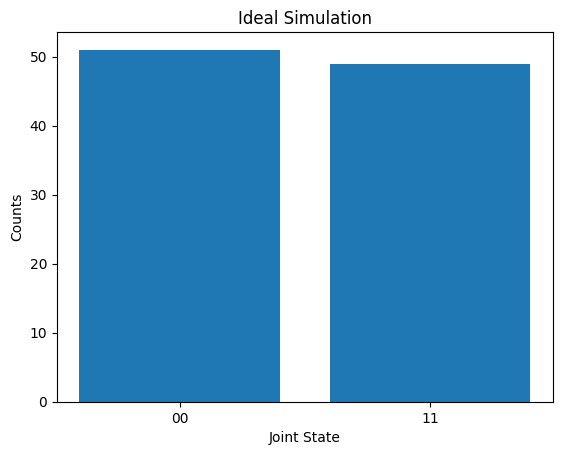

In [62]:
local_device = LocalSimulator()
ideal_bell_circuit = Circuit().h(0).cnot(control=0,target=1).measure(0).measure(1)
task = local_device.run(ideal_bell_circuit, shots=100)
counts = task.result().measurement_counts
print("Default Simulator: ")
print(counts)
plt.bar(counts.keys(), counts.values())
plt.xlabel('Joint State')
plt.ylabel('Counts')
plt.title('Ideal Simulation');


We can also add noise directly to a circuit and create a LocalSimulator capable of handling noise. Let's try the same simulation again, now adding some depolarization noise:


Noisy Simulator:
Counter({'11': 46, '00': 36, '10': 11, '01': 7})
T  : │         0         │         1         │  2  │
      ┌───┐ ┌───────────┐       ┌───────────┐ ┌───┐ 
q0 : ─┤ H ├─┤ DEPO(0.1) ├───●───┤ DEPO(0.1) ├─┤ M ├─
      └───┘ └───────────┘   │   └───────────┘ └───┘ 
                          ┌─┴─┐ ┌───────────┐ ┌───┐ 
q1 : ─────────────────────┤ X ├─┤ DEPO(0.1) ├─┤ M ├─
                          └───┘ └───────────┘ └───┘ 
T  : │         0         │         1         │  2  │


Text(0.5, 1.0, 'Noisy Simulation')

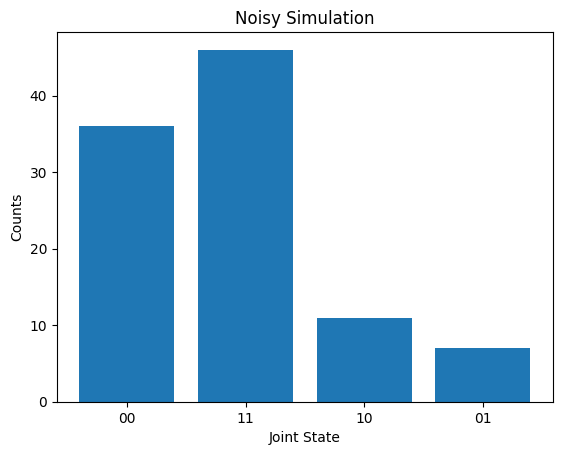

In [66]:
noise = Noise.Depolarizing(probability=0.1)
noisy_local_device = LocalSimulator("braket_dm")
noisy_bell_circuit = Circuit().h(0).cnot(control=0,target=1).apply_gate_noise(noise).measure(0).measure(1)
noisy_task = noisy_local_device.run(noisy_bell_circuit, shots=100)
noisy_counts = noisy_task.result().measurement_counts
print("\nNoisy Simulator:")
print(noisy_counts)
print(noisy_bell_circuit)
plt.bar(noisy_counts.keys(), noisy_counts.values())
plt.xlabel('Joint State')
plt.ylabel('Counts')
plt.title('Noisy Simulation')

# 2. Sending Circuits to Outside Simulators and Physical Hardware

Great! We were able to build some quantum circuits and run them locally. But these are just simulations of what SHOULD happen. Braket also provides the option to run on physical quantum chips, as well as outside qubit simulators.

First, we will cover the AWS hardware simulators. To find a list of devices, go to the AWS Management Console -> Amazon Braket -> Devices. Click on one of the available devices and locate its "Device ARN"; this is what we will connect to. Copy the ARN and use it as the input to the AwsDevice() class constructor:

In [34]:
#device = AwsDevice("YOUR-DEVICE-ARN-HERE")
simulator_device = AwsDevice("arn:aws:braket:::device/quantum-simulator/amazon/sv1")

device_operations = simulator_device.properties.dict()['action']['braket.ir.jaqcd.program']['supportedOperations']
print("Using device: ", simulator_device.name)
print("Supported Gates: ", device_operations)

Using device:  SV1
Supported Gates:  ['ccnot', 'cnot', 'cphaseshift', 'cphaseshift00', 'cphaseshift01', 'cphaseshift10', 'cswap', 'cy', 'cz', 'ecr', 'h', 'i', 'iswap', 'pswap', 'phaseshift', 'rx', 'ry', 'rz', 's', 'si', 'swap', 't', 'ti', 'unitary', 'v', 'vi', 'x', 'xx', 'xy', 'y', 'yy', 'z', 'zz']


Once we are connected to the hardware simulator, we can run our tasks just like before:


 SV1  Simulator:
Counter({'11': 51, '00': 49})


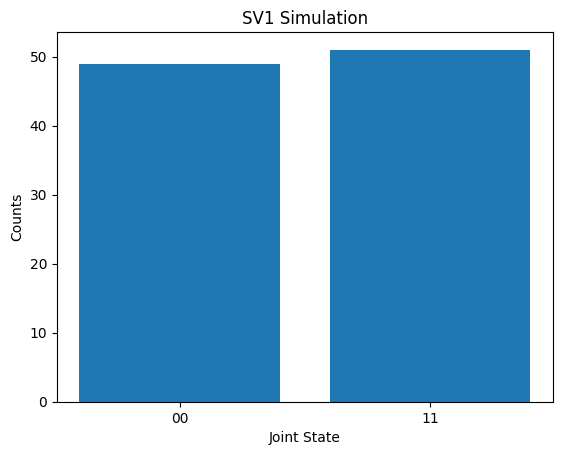

In [35]:
bell_circuit = Circuit().h(0).cnot(control=0,target=1).measure(0).measure(1)
task = simulator_device.run(bell_circuit, shots=100)
counts = task.result().measurement_counts
print("\n", simulator_device.name, " Simulator:")
print(counts)
plt.bar(counts.keys(), counts.values())
plt.xlabel('Joint State')
plt.ylabel('Counts')
plt.title(simulator_device.name + ' Simulation');


In addition to the results, we are also able to obtain some other metadata from the run we send to AWS Braket:

In [36]:
metadata = task.metadata()
task_id = task.id

print("Task Date:", metadata['ResponseMetadata']['HTTPHeaders']['date'])
print("Shots taken:", metadata["shots"])
#print("task_id:", task_id)


Task Date: Thu, 02 May 2024 02:22:25 GMT
Shots taken: 100


This can be useful to retrieve the data from a specific task without having to rerun the entire simulation. Either save the task id as shown above, or go to the AWS Management Console -> Amazon Braket -> Quantum Tasks, and from here click on the task you want to load. Copy the "Quantum Task ARN" for the task you would like to load. Additionally, this window will show you the task details and provides a link to "Results" which stores the simulation results in S3 (the AWS data bucket).

***NOTE:*** If you run the task above + metadata loading and then reload it below, the results will be exactly the same, it will not rerun the simulation and it will not change no matter how many times it is loaded.

***NOTE AGAIN:*** The time to load and display results is much shorter than sending the simulation to actually run. This feature is particularly useful when scaling to large simulations that take longer to run, and it is also useful because you might have to wait until your turn on the machine to simulate.


 Loaded Successfully...
 SV1  Simulator:
Counter({'11': 51, '00': 49})


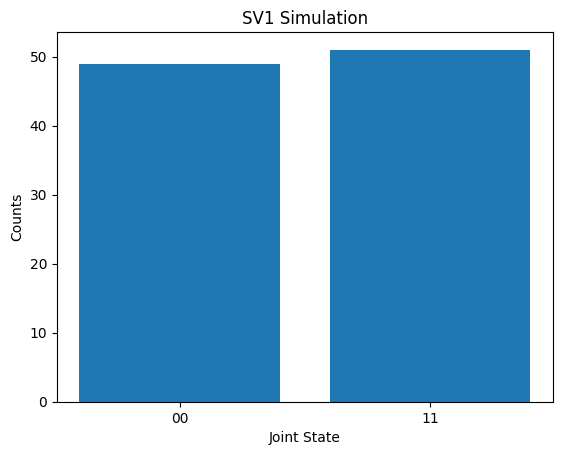

In [37]:
task_load = AwsQuantumTask(arn=task_id)
counts = task_load.result().measurement_counts
print("\n Loaded Successfully...\n", simulator_device.name, " Simulator:")
print(counts)
plt.bar(counts.keys(), counts.values())
plt.xlabel('Joint State')
plt.ylabel('Counts')
plt.title(simulator_device.name + ' Simulation');

Let's move on to running our circuits on physical hardware. Looking under the "Devices" tab from before, AWS offers access to 7 different Quantum Processing Units (as of April 27th, 2024). Some of these are Offline, Under Maintenence, or Reservation Only, so we must pick one that has the AVAILABLE NOW tag. This may change from day to day. You can check information on the device through the Management Console, or by printing below:

***NOTE:*** If you want to use gate based computation as before, make sure your device description includes "unviversal gate-model", as some devices use Analog Hamiltonian Simulation which requires a different circuit representation (not covered in this tutorial).

In [5]:
#device = AwsDevice("YOUR-DEVICE-ARN-HERE")
QPU_device = AwsDevice("arn:aws:braket:us-east-1::device/qpu/ionq/Harmony")

print("Checking availability...")
if (QPU_device.is_available):
    print("AVAILABLE!")
    print("Using device:", QPU_device.name, "located at", QPU_device.properties.service.deviceLocation)
    print("Device Price:", QPU_device.properties.service.deviceCost)
    print("\nDevice Schedule: ")
    available_days = QPU_device.properties.service.executionWindows
    for day in available_days:
        print(day.executionDay, "starts on", day.windowStartHour, "and ends on", day.windowEndHour)
    print("\nDevice Docs:", QPU_device.properties.service.deviceDocumentation)
    print("Shots Range:", QPU_device.properties.service.shotsRange)
else:
    print("Not Available, please try a different device.")

Checking availability...
AVAILABLE!
Using device: Harmony located at Maryland, USA
Device Price: price=0.01 unit='shot'

Device Schedule: 
ExecutionDay.WEEKDAYS starts on 12:00:00 and ends on 03:00:00

Device Docs: imageUrl='http://d1.awsstatic.com/re19/Braket/IonQ%20Logo.59ea92b40cff5a2c2e90d9d981b864c2f424c5a8.png' summary='Universal gate-model QPU based on trapped ions' externalDocumentationUrl='https://ionq.com/quantum-systems/harmony'
Shots Range: (1, 10000)


Run the same circuit as before, but on physical hardware this time:

***NOTE:*** There is a price to each shot! DO NOT run without taking this into consideration!

***NOTE AGAIN:*** DO NOT RUN MULTIPLE TIMES! Running this block will send the job to the queue and will keep your place in line EVEN IF YOU STOP THIS CODE BLOCK. ***Running multiple times will send multiple jobs to the queue, and you will be charged for each job sent.*** If you wish to cancel a task, you can checkbox it within the "Quantum Tasks" window, click the "Actions" dropdown, and click "Cancel quantum task". You will not be charged for cancelling a job.

In [ ]:
#LAST RUN TIMER: 95 minutes, 44 seconds, STILL QUEUED. 
#Running this cell will send your job to the AWS queue

bell_circuit = Circuit().h(0).cnot(control=0,target=1).measure(0).measure(1)
print("Sending quantum task to QPU!\nWaiting on result...")
task = QPU_device.run(bell_circuit, shots=100)
counts = task.result().measurement_counts
print("\n", QPU_device.name, " Simulator:")
print(counts)
plt.bar(counts.keys(), counts.values())
plt.xlabel('Joint State')
plt.ylabel('Counts')
plt.title(QPU_device.name + ' Simulation');

QPU_task_id = task.id

We will do the same loading as before in case there are no QPUs available or it takes too long (make sure to take the ARN of a completed task):


 Loaded Successfully...
 Harmony  QPU:
Counter({'11': 56, '00': 43, '10': 1})


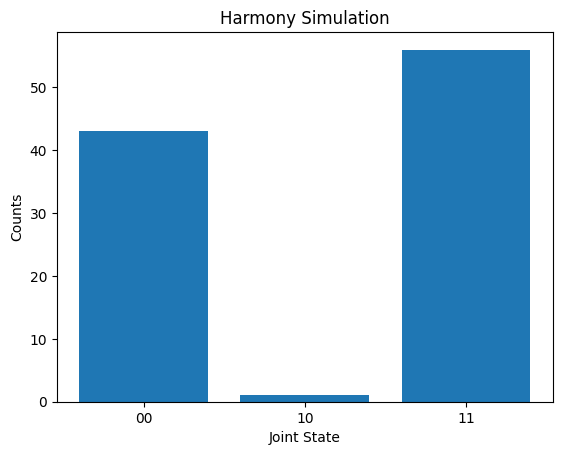

In [7]:
# If you would like the ARN of my run, please contact through email, I am not sure if it is 100% safe to post publicly. The results are also shown below.
# QPU_task_id = "YOUR-TASK-ARN-HERE" 

QPU_task_load = AwsQuantumTask(arn=QPU_task_id)
counts = QPU_task_load.result().measurement_counts
print("\n Loaded Successfully...\n", QPU_device.name, " QPU:")
print(counts)
plt.bar(counts.keys(), counts.values())
plt.xlabel('Joint State')
plt.ylabel('Counts')
plt.title(QPU_device.name + ' Simulation');

# 3. Hybrid Algorithms (see disclaimer at beginning)

Up to this point, we have created simple quantum circuits and ran them both locally and on hardware simulators/QPUs.

As a final part to this tutorial, we will consider running [Hybrid Algorithms](https://github.com/amazon-braket/amazon-braket-examples/tree/main/examples/hybrid_quantum_algorithms) which utilize both classical and quantum components as a dual technology. The linked quantum algorithms are of particular interest as they highlight the potential for quantum computing applications, but they are very in depth and will not be covered in this tutorial.

We will focus on creating a simple hybrid job to run. When a hybrid job is created, a containerized EC2 environment is created on AWS to host your program. EC2 stands for "Elastic Cloud Compute", which allows the user to rent a virtual computing space on the AWS Cloud. 

To create a hybrid job, use the @hybrid_job decorator to annotate a function, which Braket will recognize and automatically transform the code to a hybrid job script. The script is then run on EC2. Hybrid jobs benefit from parametric compilation, meaning the circuit is only compiled once and iterated over multiple times to reduce runtime for variational algorithms. The log_metric() function can be used to graph results, which can be found under Amazon Braket -> Hybrid Jobs -> YOUR-JOB -> Monitor

***NOTE:*** Braket is fully integrated with [PennyLane](https://pennylane.ai/), a quantum machine learning platform, and comes with its own set of optimizations (not covered here). Such applications benefit greatly from the duality of hybrid jobs.

***NOTE AGAIN:*** An additional few minutes are needed to set up the EC2 instance for the Hybrid Job.

In [29]:
#device_arn = "YOUR-DEVICE-ARN-HERE"
hybrid_device_arn = "arn:aws:braket:::device/quantum-simulator/amazon/sv1"

@hybrid_job(device=hybrid_device_arn)
def run_hybrid_job(num_tasks):
    hybrid_device = AwsDevice(hybrid_device_arn)
    bell_circuit = Circuit().h(0).cnot(control=0,target=1).measure(0).measure(1)
    results = []

    print("Starting hybrid job...")
    for task_num in range(num_tasks):
        task = hybrid_device.run(bell_circuit, shots=100)
        results.append(task.result().measurement_counts)
        log_metric(metric_name="State_11_counts", iteration_number=task_num, value=task.result().measurement_counts["11"])

    return results

hybrid_job = run_hybrid_job(5)
print(hybrid_job.result())

{'result': [Counter({'11': 64, '00': 36}), Counter({'11': 51, '00': 49}), Counter({'11': 56, '00': 44}), Counter({'00': 57, '11': 43}), Counter({'11': 56, '00': 44})]}


# 4. Simple Notification Services

One thing to note about this tutorial is that some processes take very long! Whether you are waiting your turn in line or waiting for a heavy-duty algorithm to finish, you don't want to sit around checking every few minutes. Because Braket is integrated with all of AWS's other cloud capabilities, you can set up automatic notifications to notify you of your results. Follow the instructions [here](https://github.com/amazon-braket/amazon-braket-examples/blob/main/examples/braket_features/Getting_notifications_when_a_quantum_task_completes/Getting_notifications_when_a_quantum_task_completes.ipynb) if you are interested. This notebook is connected to email notifications, but you can choose other forms of notification.

AWS automatically created an S3 (simple storage service) bucket for Braket. This is where it stores all of the results from running our quantum circuits. We can connect this to SNS (Simple Notification Services) so that whenever someting is added/removed from the bucket (example, our task finishes and is uploaded), we get a notification. 

This concludes the tutorial. We have covered setting up an AWS environment, creating simple Braket circuits, running ideal and noisy tests locally, running simulations on QPUs and hardware simulators, loading previous tasks, combining quantum and classical into hybrid tasks, and covered the automatic notification service (SNS).

